#### Video Link  : https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
#### Github link : https://github.com/karpathy/makemore

### In last tutorial we developed a bigram model which take one character from past and will predict the next character in the sequnce but it was not working well cause we were using only one character from past it like context with only one character so in this tutorial we are going to train a model which will be having more conext from past like last context length and which wil lead us having good accuracy for predicting next character in the sequence.

### In last video we just used one character from past and tried to predict next in the sequence cause we had 27 unique character our look up take became 27*27 = 729

### What if we consider 2 from past and will try to predict next character look up table will have shape of 27*27*27 =19,683It will start growing exponentially w.r.t context length right

 ### It will explode if we start to take more and more context length so in this tutuoral we are going to develope MLP(Multi Layer perceptron) for the same.We will try to predict probability of the next character using MLP rather than loop up table.
 
 ### In MLP we will develope the vector of 30*17000 where 30 = vector size, 17000=vocab size
 
 ## Paper used to developed MLP : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


### In the paper they have vocabulary of words but we will stick to the character levek vocabulary for better unsedstanding
### In the paper they develope 30 dimension feature vector for each word

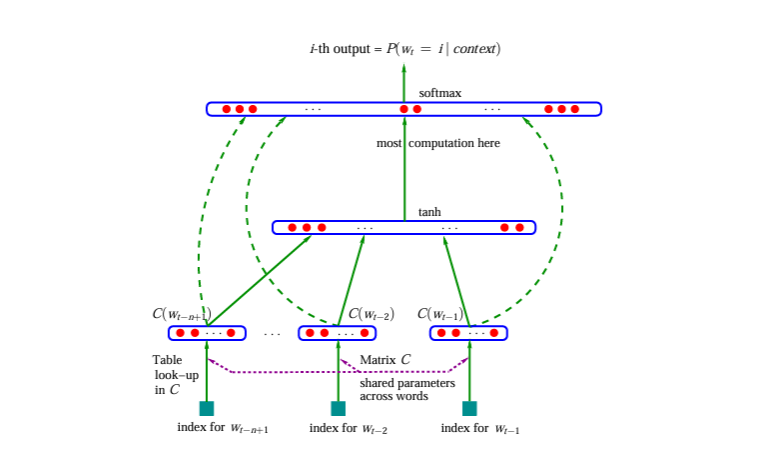

### We are going develope above network in python
### Our parameter's will be 1) weights and biases of the last linear layer before soft max 2) weights and biases the fully connected layer before tanh 3) embedding vector's of the embeding layer

## Imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib inline to creating seperate window for matplotlib figures it will draw it in cell output instead

## Read dataset

In [2]:
words = open("/kaggle/input/eureka-labs/names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars     = sorted(list(set(''.join(words))))
stoi      = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos      = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build dataset

block_size = 3 # context length : how many characters do we take to predict next one
X, Y       = [],[]

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] #crop and apppend
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Creating input layer and embedings

### in the paper they have developed 17000 * 30 shape lookup table. But as we are working on character level we will developen 2 * 27 shape look up table here 2 is random we can change it

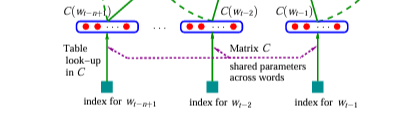

In [7]:
C = torch.randn((27,2)) #Random initialization and we will optmize it while training

In [8]:
C[5]

tensor([ 1.3940, -0.3043])

In [9]:
#we can produce the same using one hot encoding
one_hot_encoded = F.one_hot(torch.tensor(5), num_classes=27).float()
print(one_hot_encoded)
emb_temp = one_hot_encoded @ C
emb_temp, C[5]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


(tensor([ 1.3940, -0.3043]), tensor([ 1.3940, -0.3043]))

In [10]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:
emb[0]

tensor([[-0.9656, -2.2743],
        [-0.9656, -2.2743],
        [-0.9656, -2.2743]])

In [12]:
emb[:,0,:].shape

torch.Size([32, 2])

## Creating hidden layer
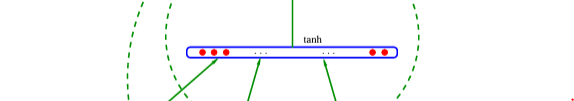

In [13]:
W1 = torch.randn((6,100)) # 6 = 3*2 last dimensions of the embedings ->DISCUSS
b1 = torch.randn(100)

In [14]:
# emb @ W1 + b1

In [15]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]], 1).shape

torch.Size([32, 6])

In [16]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])